<a href="https://colab.research.google.com/github/joey0320/reversemethod/blob/horn_array/Reverse_Horn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
#4/0AEpufuJ_nbX2dmW9b_yXFnB9ZujzNhSBbcBUvxn2H0lTVVMyz4e-Q0

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
pip install neptune-client

In [3]:
import neptune

neptune.init(
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiZjY2Y2M1MjktNzljYy00MTFjLWE1NTQtOTAxYTFhMmNjM2VhIn0=",
    project_qualified_name="joey0320/reverse-1"
)

Project(joey0320/reverse-1)

In [0]:
import sys
sys.path.append('/content/libs')

In [5]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
import matplotlib.pyplot as plt
import math
import os
from tqdm import tqdm
import time
import cv2
from DataCaller import DataCaller
from EarlyStopper import *
from Net import *
from train_test import *
from utils import *

#use gpu    please somebody buy me a gpu .......
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

#Global variables
config = {
    'load_data':True,
    'load_test_data':True,

    'batch_size':48,
    'val_batch_size':16,
    'learning_rate':4e-4,
    'epochs':1000,
    'patience':5,

    'img_size':64,
    'img_channels':4,

    'train_label_size':6,
    'test_label_size':3,

    'output1':1,
    'output2':2,
    'result_label':4,

    'weight':torch.tensor([2.0, 2.0, 1.0, 0.5]),
}
MODEL_NAME = f"model-{int(time.time())}"
neptune.create_experiment(name='rev1', params=config, upload_source_files=['libs/DataCaller.py',
                                                                           'libs/EarlyStopper.py',
                                                                           'libs/Net.py',
                                                                           'libs/train_test.py',
                                                                           'libs/utils.py'])


cuda
https://ui.neptune.ai/joey0320/reverse-1/e/REV-7


Experiment(REV-7)

In [0]:
BASE_PATH = '/content/gdrive/My Drive/Colab Notebooks/Reverse_Method_Horn/data'
TRAIN_DATA_PATH = os.path.join(BASE_PATH, 'test_gen/train')
VAL_DATA_PATH = os.path.join(BASE_PATH, 'test_gen/val')
TEST_DATA_PATH = os.path.join(BASE_PATH, 'test_gen/test')

In [7]:

if config['load_data']:
    trainsets = []
    valsets = []
    for f in tqdm(os.listdir(TRAIN_DATA_PATH)):
      path = os.path.join(TRAIN_DATA_PATH, f)
      trainset = DataCaller(path, config['img_size'], config['train_label_size'])
      print(trainset.__len__())
      trainsets.append(trainset)

    for f in tqdm(os.listdir(VAL_DATA_PATH)):
      path  = os.path.join(VAL_DATA_PATH, f)
      valset = DataCaller(path, config['img_size'], config['train_label_size'])
      print(valset.__len__())
      valsets.append(valset)

if config['load_test_data']:
    testsets = []
    for f in tqdm(os.listdir(TEST_DATA_PATH)):
      path  = os.path.join(TEST_DATA_PATH, f)
      testset = DataCaller(path, config['img_size'], config['test_label_size'])
      print(testset.__len__())
      testsets.append(testset)

    trainset = ConcatDataset(trainsets)
    print(trainset.__len__())
    valset = ConcatDataset(valsets)
    print(valset.__len__())
    testset = ConcatDataset(testsets)
    print(testset.__len__())  

 50%|█████     | 1/2 [00:01<00:01,  1.61s/it]

50


  0%|          | 0/1 [00:00<?, ?it/s]

50


  0%|          | 0/1 [00:00<?, ?it/s]

50


100%|██████████| 1/1 [00:01<00:00,  1.57s/it]

50
100
50
50


In [0]:
  #define dataloaders
trainloader = DataLoader(trainset, batch_size = config['batch_size'], shuffle=True)
valloader = DataLoader(valset, batch_size=config['batch_size'], shuffle=True)
testloader = DataLoader(testset, batch_size=1, shuffle=False)

In [9]:
cnt = 0
for i, data in enumerate(trainloader):
    x, y = data
    filter_input(x)
    x = np.array(x)
    x = x.reshape(-1, config['img_channels'], config['img_size'], config['img_size'])

    print(x[0])
    print(x[0].shape)

    print(y[0])
    cnt += 1
    if cnt==1:
      break

[[[24.527   23.894   21.849   ...  0.       0.       0.     ]
  [24.527   23.9     21.875   ...  0.       0.       0.     ]
  [24.527   23.917   21.951   ...  0.       0.       0.     ]
  ...
  [24.527   23.916   21.951   ...  0.       0.       0.     ]
  [24.527   23.9     21.874   ...  0.       0.       0.     ]
  [24.527   23.894   21.849   ...  0.       0.       0.     ]]

 [[22.412   24.103   24.442   ...  0.       0.       0.     ]
  [22.412   24.097   24.442   ...  0.       0.       0.     ]
  [22.412   24.08    24.442   ...  0.       0.       0.     ]
  ...
  [22.412   24.08    24.441   ...  0.       0.       0.     ]
  [22.412   24.097   24.442   ...  0.       0.       0.     ]
  [22.412   24.103   24.442   ...  0.       0.       0.     ]]

 [[13.7     19.829   22.859   ...  0.       0.       0.     ]
  [13.7     19.808   22.836   ...  0.       0.       0.     ]
  [13.7     19.743   22.765   ...  0.       0.       0.     ]
  ...
  [13.7     19.743   22.764   ...  0.       0.  

In [10]:
net = Net(config['img_channels'], config['output1'], config['output2'])
net.to(device)
train_losses, valid_losses = train(net, trainloader, valloader, config['weight'], config['epochs'], config['learning_rate'], 
                                   config['img_channels'], config['img_size'], MODEL_NAME, 
                                   config['patience'], 1, device)

  0%|          | 2/1000 [00:01<13:08,  1.27it/s]


loss :  155.84308624267578 val loss :  173.86473846435547 

Validation loss decreased (inf --> 173.864738).  Saving model ...

loss :  165.33609008789062 val loss :  152.17639923095703 

Validation loss decreased (173.864738 --> 152.176399).  Saving model ...


  0%|          | 4/1000 [00:01<09:41,  1.71it/s]


loss :  167.94542439778647 val loss :  131.25177383422852 

Validation loss decreased (152.176399 --> 131.251774).  Saving model ...

loss :  170.1469472249349 val loss :  129.76523971557617 

Validation loss decreased (131.251774 --> 129.765240).  Saving model ...


  1%|          | 6/1000 [00:01<07:13,  2.29it/s]


loss :  155.03096516927084 val loss :  146.5143814086914 

EarlyStopping counter: 1 out of 5

loss :  147.3236846923828 val loss :  127.57420349121094 

Validation loss decreased (129.765240 --> 127.574203).  Saving model ...

loss :  131.07652282714844 val loss :  139.3704948425293 

EarlyStopping counter: 1 out of 5


  1%|          | 10/1000 [00:01<04:19,  3.81it/s]


loss :  124.38951873779297 val loss :  97.51263427734375 

Validation loss decreased (127.574203 --> 97.512634).  Saving model ...

loss :  121.3477554321289 val loss :  82.78516006469727 

Validation loss decreased (97.512634 --> 82.785160).  Saving model ...

loss :  85.74702962239583 val loss :  67.04410743713379 

Validation loss decreased (82.785160 --> 67.044107).  Saving model ...


  1%|▏         | 13/1000 [00:02<02:54,  5.67it/s]


loss :  62.422892252604164 val loss :  60.055362701416016 

Validation loss decreased (67.044107 --> 60.055363).  Saving model ...

loss :  68.9615249633789 val loss :  64.29091835021973 

EarlyStopping counter: 1 out of 5

loss :  64.23725891113281 val loss :  41.286298751831055 

Validation loss decreased (60.055363 --> 41.286299).  Saving model ...


  2%|▏         | 15/1000 [00:02<02:28,  6.62it/s]


loss :  52.09375254313151 val loss :  30.236631393432617 

Validation loss decreased (41.286299 --> 30.236631).  Saving model ...

loss :  43.37224451700846 val loss :  33.66238784790039 

EarlyStopping counter: 1 out of 5

loss :  39.0602060953776 val loss :  18.78254222869873 

Validation loss decreased (30.236631 --> 18.782542).  Saving model ...


  2%|▏         | 19/1000 [00:02<01:57,  8.32it/s]


loss :  32.64894803365072 val loss :  18.25338125228882 

Validation loss decreased (18.782542 --> 18.253381).  Saving model ...

loss :  27.557173411051433 val loss :  16.210082530975342 

Validation loss decreased (18.253381 --> 16.210083).  Saving model ...

loss :  26.321749369303387 val loss :  17.35854721069336 

EarlyStopping counter: 1 out of 5


  2%|▏         | 21/1000 [00:02<01:50,  8.88it/s]


loss :  23.7549991607666 val loss :  14.482529640197754 

Validation loss decreased (16.210083 --> 14.482530).  Saving model ...

loss :  17.910441716512043 val loss :  9.665153503417969 

Validation loss decreased (14.482530 --> 9.665154).  Saving model ...

loss :  22.995972951253254 val loss :  20.469335079193115 

EarlyStopping counter: 1 out of 5


  2%|▎         | 25/1000 [00:03<01:39,  9.84it/s]


loss :  25.910348892211914 val loss :  18.217342376708984 

EarlyStopping counter: 2 out of 5

loss :  19.012338638305664 val loss :  11.37115740776062 

EarlyStopping counter: 3 out of 5

loss :  23.29578463236491 val loss :  10.662262201309204 

EarlyStopping counter: 4 out of 5


  2%|▎         | 25/1000 [00:03<02:14,  7.27it/s]



loss :  21.09667142232259 val loss :  15.693092823028564 

EarlyStopping counter: 5 out of 5
Early stopping


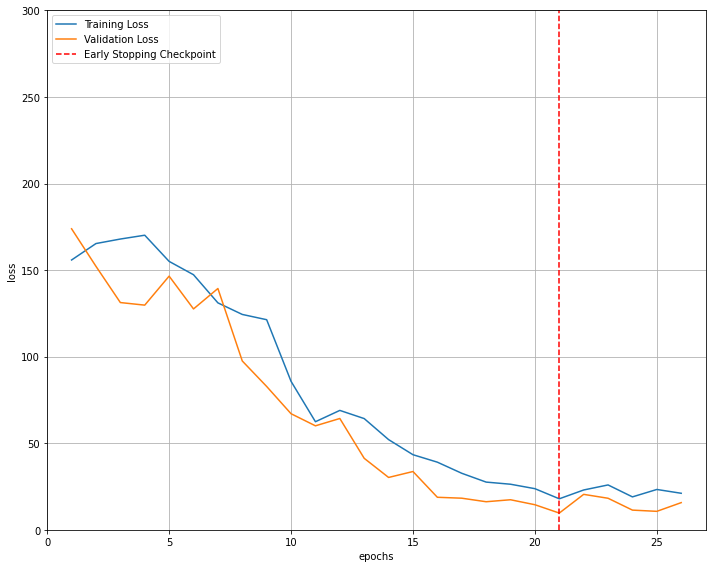

In [11]:
graph_limit = 300
save_plot(train_losses, valid_losses, graph_limit)

In [12]:

test(net, testloader, config['img_channels'], config['img_size'], config['result_label'], device)

[array([[4.140186  , 3.6246712 , 1.8539729 , 0.37556845]], dtype=float32), array([[4.3730307, 3.8266735, 1.980751 , 0.3915941]], dtype=float32), array([[6.6495686 , 6.0620685 , 3.2633238 , 0.44549495]], dtype=float32), array([[4.0138307, 3.5205252, 1.7839842, 0.3700313]], dtype=float32), array([[4.4831595 , 3.9144018 , 2.0405545 , 0.40806502]], dtype=float32), array([[4.468825  , 3.9216917 , 2.0171    , 0.39669484]], dtype=float32), array([[4.505936  , 3.9452746 , 2.0413678 , 0.38741392]], dtype=float32), array([[4.728722 , 4.1305113, 2.1922767, 0.4140584]], dtype=float32), array([[5.018684  , 4.4495053 , 2.3188715 , 0.41209513]], dtype=float32), array([[4.032648 , 3.544815 , 1.7812276, 0.351494 ]], dtype=float32), array([[4.162008  , 3.6527035 , 1.8652558 , 0.37586838]], dtype=float32), array([[6.7454457 , 6.0987124 , 3.3342125 , 0.47993785]], dtype=float32), array([[4.2305923, 3.7083328, 1.906385 , 0.3804267]], dtype=float32), array([[4.9305863 , 4.360103  , 2.2808027 , 0.40321988]],

In [13]:
for num, data in enumerate(testloader):
  x, y = data
  print(y)

tensor([[5.5521, 4.6817, 0.7301]])
tensor([[5.0900, 4.7484, 0.6404]])
tensor([[5.6370e+00, 5.9667e+00, 4.1027e-04]])
tensor([[5.5963, 4.8377, 0.7775]])
tensor([[4.5830, 4.4386, 0.6294]])
tensor([[3.6835, 4.4943, 0.7075]])
tensor([[4.7240, 5.5355, 0.5801]])
tensor([[4.7580, 3.7402, 0.5234]])
tensor([[3.2504, 4.8779, 0.5191]])
tensor([[5.1893, 5.6723, 0.7715]])
tensor([[5.3071, 4.7443, 0.7291]])
tensor([[4.7403, 3.0509, 0.0949]])
tensor([[5.5881, 4.4529, 0.6636]])
tensor([[3.6282, 4.6569, 0.4947]])
tensor([[3.0960, 4.8441, 0.2846]])
tensor([[3.1486, 4.4687, 0.1512]])
tensor([[3.3693, 3.6165, 0.1151]])
tensor([[3.5672, 3.1280, 0.4989]])
tensor([[3.8456, 4.6158, 0.5460]])
tensor([[4.4973, 4.6074, 0.3496]])
tensor([[3.3718, 4.4711, 0.6699]])
tensor([[5.6218, 3.8109, 0.1637]])
tensor([[4.6949, 4.9209, 0.3275]])
tensor([[3.6179, 5.8438, 0.0645]])
tensor([[3.3171, 3.4261, 0.1307]])
tensor([[4.8629, 4.7211, 0.0409]])
tensor([[5.7936, 5.1860, 0.5795]])
tensor([[3.1902, 5.5813, 0.7339]])
tensor([